In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : N/A
[INFO    ] Using python     : 3.9.12 (main, Jun  1 2022, 11:38:51) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.5.1
[INFO    ] Using tensorflow : 2.6.0
[INFO    ] Using keras      : 2.6.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2022-06-28 03:00:01.910783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-28 03:00:01.910836: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[INFO    ] Using emtf-nnet  :

In [3]:
# Preamble (ML additional stuff)
import h5py
import pandas as pd
import seaborn as sns

#import tensorflow_probability as tfp
#import tensorflow_model_optimization as tfmot

In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 10_000
#maxevents = -1

# NN pruning: True/False
do_pruning = False

# NN quantization: True/False
do_quantization = False

# Input files
features_fname = 'features_dxy.h5'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 10000


### Load data

In [5]:
def load_features(fname):
  logger.info('Loading from {}'.format(fname))
  with h5py.File(fname, 'r') as loaded:
    features = np.array(loaded['features'])
    truths = np.array(loaded['truths'])
    noises = np.array(loaded['noises'])
  logger.info('features: {} truths: {} noises: {}'.format(
      (features.shape, features.dtype.name),
      (truths.shape, truths.dtype.name),
      (noises.shape, noises.dtype.name)))
  return (features, truths, noises)

In [6]:
# Load features and truths
features, truths, noises = load_features(features_fname)

[INFO    ] Loading from features_dxy.h5
[INFO    ] features: ((801909, 40), 'int32') truths: ((801909, 10), 'float32') noises: ((1548049, 40), 'int32')


In [7]:
from emtf_nnet.architecture import endless_nnet_v3

tf.config.optimizer.set_jit(True)  # enable XLA
#tf.config.threading.set_inter_op_parallelism_threads(32)
#tf.config.threading.set_intra_op_parallelism_threads(32)

# Split into train/test
x_train, x_test, y_train, y_test = endless_nnet_v3.get_x_y_data(
    features, truths, batch_size=8192)
logger.info('x_train: {} y_train: {} x_test: {} y_test: {}'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (606208, 40) y_train: (606208, 1) x_test: (195701, 40) y_test: (195701, 1)


### Create model

In [8]:
# Set hyperparameters
learning_rate = 0.005
final_learning_rate = learning_rate * 0.02
gradient_clipnorm = 10.
warmup_epochs = 30
epochs = warmup_epochs + 120
batch_size = 2048

num_train_samples = x_train.shape[0]
callbacks = [emtf_nnet.keras.callbacks.LearningRateLogger(),]
logger.info('learning_rate: {} final_learning_rate: {} epochs: {} batch_size: {}'.format(
    learning_rate, final_learning_rate, epochs, batch_size))

# Create model
preprocessing_layer = endless_nnet_v3.create_preprocessing_layer(x_train)
regularization_layer = endless_nnet_v3.create_regularization_layer(noises, batch_size=batch_size)
lr_schedule = endless_nnet_v3.create_lr_schedule(
    num_train_samples, epochs=epochs, warmup_epochs=warmup_epochs, batch_size=batch_size,
    learning_rate=learning_rate, final_learning_rate=final_learning_rate)
optimizer = endless_nnet_v3.create_optimizer(
    lr_schedule, gradient_clipnorm=gradient_clipnorm)
model = endless_nnet_v3.create_model(
    preprocessing_layer, regularization_layer, optimizer)
model.summary()

[INFO    ] learning_rate: 0.005 final_learning_rate: 0.0001 epochs: 150 batch_size: 2048
2022-06-28 03:00:08.471587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "nnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (FeatureNormal (None, 40)                80        
_________________________________________________________________
dense (MutatedDense)         (None, 28)                1120      
_________________________________________________________________
batch_normalization (Mutated (None, 28)                112       
_________________________________________________________________
activation (TanhActivation)  (None, 28)                0         
_________________________________________________________________
dense_1 (MutatedDense)       (None, 24)                672       
_________________________________________________________________
batch_normalization_1 (Mutat (None, 24)                96        
_________________________________________________________________
activation_1 (TanhActivation (None, 24)                0

### Train model

In [9]:
# Training utils
class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    train_value = self.history.history[self.metric]
    val_value = self.history.history['val_' + self.metric]
    lr_value = self.history.history['lr']
    maxnorm_value = self.history.history['gradient_maxnorm']
    tup = (len(self.history.epoch), len(self.history.epoch), self.metric,
           train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {}/{} - {}: {:.4f} - {}: {:.4f}'.format(*tup))

    if len(self.history.epoch) > 10:
      fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
      ax = axs[0]
      ax.plot(self.history.epoch, lr_value, color='C0')
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Learning rate')
      ax.grid(True)
      ax = axs[1]
      ax.plot(self.history.epoch, train_value, color='C0', label='Train')
      ax.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
      ax.set_xlabel('Epochs')
      ax.set_ylabel(self.metric.replace('_', ' ').title())
      ax.set_ylim(0, 1.5)
      ax.legend(loc='upper right')
      ax.grid(True)
      plt.show()

      fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
      ax = axs[0]
      ax.plot(self.history.epoch, maxnorm_value, color='C0')
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Gradient maxnorm')
      ax.set_ylim(0, 1.5)
      ax.grid(True)
      plt.show()


class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from datetime import datetime
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    # Fit
    with os.fdopen(fd, 'w') as f:
      with contextlib.redirect_stdout(f):
        history = self.model.fit(*args, **kwargs)
    logger.info('Done training. Time elapsed: {}'.format(str(datetime.now() - start_time)))

    # Plot history
    HistoryPlotter(history).plot()
    return history

[INFO    ] Begin training ...
2022-06-28 03:00:09.469421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-28 03:00:12.042841: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f36e4011e70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 03:00:12.042898: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-06-28 03:00:12.050161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-06-28 03:00:12.085909: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[INFO    ] Done training. Time elapsed: 0:06:15.265693
[INFO    ] Epoch 150/150 - loss: 0.3714 - val_loss: 0.3737


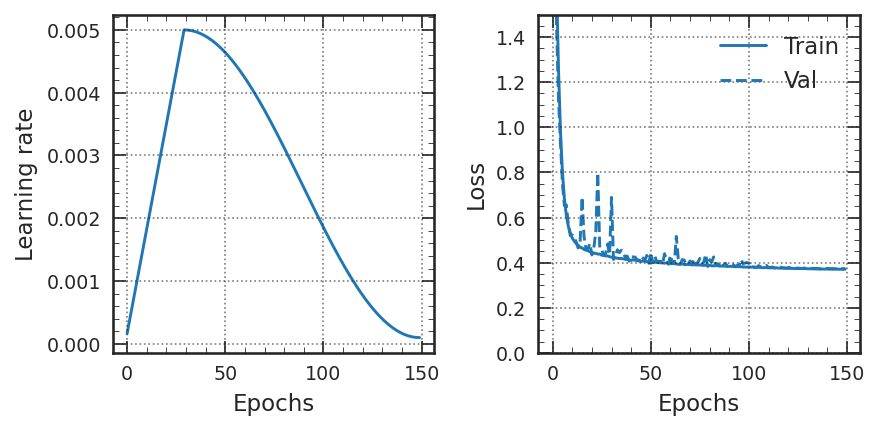

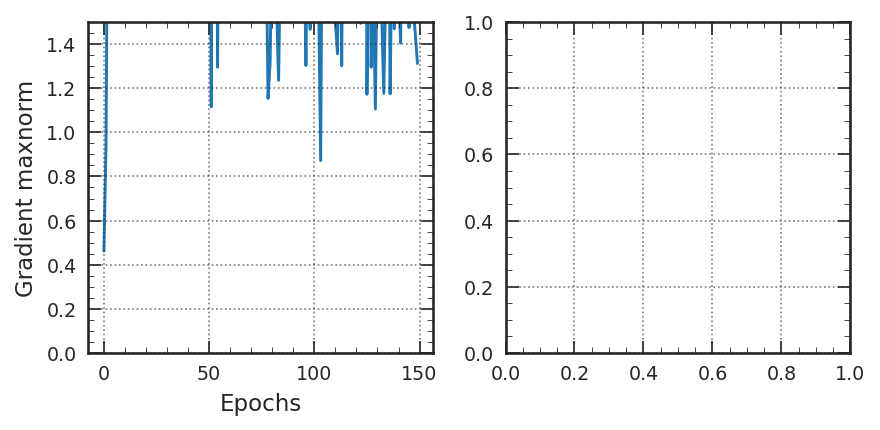

[INFO    ] Saved as nnet_model.h5


In [10]:
# Train model
history = ModelTrainer(model).fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
    callbacks=callbacks, validation_data=(x_test, y_test), shuffle=True)

# Save model
base_model = model
emtf_nnet.keras.utils.save_nnet_model(model)
logger.info('Saved as {}'.format(model.name + '.h5'))

### Pruning

In [11]:
# Create and train pruned model (1)
if do_pruning:
  pruning_callbacks = callbacks + [emtf_nnet.keras.sparsity.UpdatePruningStep()]
  pruning_learning_rate = learning_rate * 0.2
  pruning_epochs = 10
  pruning_schedule = endless_nnet_v3.create_pruning_schedule(
      num_train_samples, epochs=pruning_epochs, batch_size=batch_size)

  lr_schedule = endless_nnet_v3.create_lr_schedule(
      num_train_samples, epochs=pruning_epochs, warmup_epochs=0, batch_size=batch_size,
      learning_rate=pruning_learning_rate, final_learning_rate=pruning_learning_rate)
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)

  # Pruning loop
  layers_to_prune = 'dense'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(12, 40)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [12]:
# Create and train pruned model (2)
if do_pruning:
  layers_to_prune = 'dense_1'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(4, 28)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [13]:
# Create and train pruned model (3)
if do_pruning:
  layers_to_prune = 'dense_2'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(4, 24)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [14]:
if do_pruning:
  ## Save model
  #base_model = model
  #model = emtf_nnet.keras.sparsity.strip_pruning(pruned_model)
  #emtf_nnet.keras.utils.save_nnet_model(model)
  #logger.info('Saved as {}'.format(model.name + '.h5'))

  # Debug
  print('dense {}/{}'.format(
      np.count_nonzero(model.layers[1].weights[0]), model.layers[1].weights[0].numpy().size))
  print('dense_1 {}/{}'.format(
      np.count_nonzero(model.layers[4].weights[0]), model.layers[4].weights[0].numpy().size))
  print('dense_2 {}/{}'.format(
      np.count_nonzero(model.layers[7].weights[0]), model.layers[7].weights[0].numpy().size))
  print('dense_final {}/{}'.format(
      np.count_nonzero(model.layers[11].weights[0]), model.layers[11].weights[0].numpy().size))

### Quantization

In [15]:
# Create quantized model
if do_quantization:
  quant_learning_rate = learning_rate * 0.2
  quant_epochs = 200
  lr_schedule = endless_nnet_v3.create_lr_schedule(
      num_train_samples, epochs=quant_epochs, warmup_epochs=0, batch_size=batch_size,
      learning_rate=quant_learning_rate, final_learning_rate=final_learning_rate)
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)

  quant_model = endless_nnet_v3.create_quant_model(model, optimizer)
  quant_model.summary()

In [16]:
# Train quantized model
if do_quantization:
  history = ModelTrainer(quant_model).fit(
      x_train, y_train, batch_size=batch_size, epochs=quant_epochs, verbose=1,
      callbacks=callbacks, validation_data=(x_test, y_test), shuffle=True)

  # Save model
  base_model = model
  model = quant_model
  emtf_nnet.keras.utils.save_nnet_model(model)
  logger.info('Saved as {}'.format(model.name + '.h5'))

  # Debug
  print('dense {}/{}'.format(
      np.count_nonzero(model.layers[1].weights[0]), model.layers[1].weights[0].numpy().size))
  print('dense_1 {}/{}'.format(
      np.count_nonzero(model.layers[3].weights[0]), model.layers[3].weights[0].numpy().size))
  print('dense_2 {}/{}'.format(
      np.count_nonzero(model.layers[5].weights[0]), model.layers[5].weights[0].numpy().size))
  print('dense_final {}/{}'.format(
      np.count_nonzero(model.layers[8].weights[0]), model.layers[8].weights[0].numpy().size))

### Evaluate model

In [17]:
# Make predictions
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

# Subsets of x_test, y_test_true, y_test_pred
index_array = np.arange(x_test.shape[0])
shuffle = True
if shuffle:
  np.random.shuffle(index_array)

x_test_1 = x_test[index_array[:maxevents]]
y_test_true_1 = y_test_true[index_array[:maxevents]]
y_test_pred_1 = y_test_pred[index_array[:maxevents]]

/tmp/ipykernel_9199/4252934798.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(xx, yy, bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)


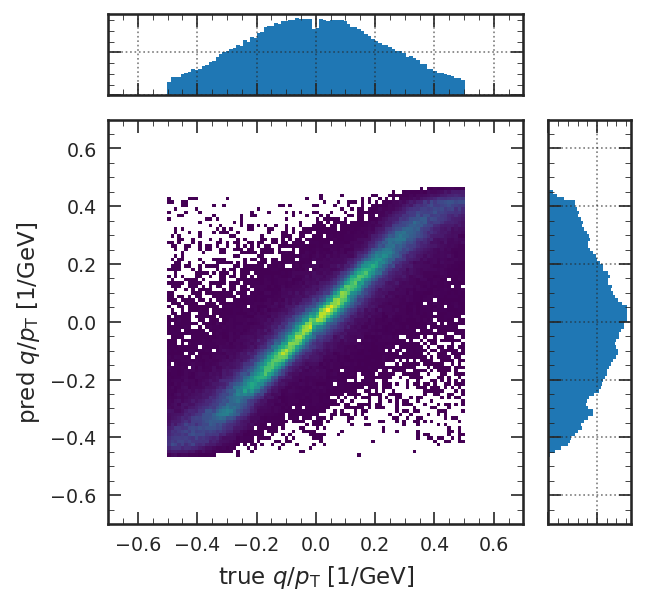

In [18]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

ax.hist2d(xx, yy, bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
ax_top.hist(xx, bins=120, range=(-0.7,0.7))
ax_top.tick_params(labelbottom=False, labelleft=False)
ax_right.hist(yy, bins=120, range=(-0.7,0.7), orientation='horizontal')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

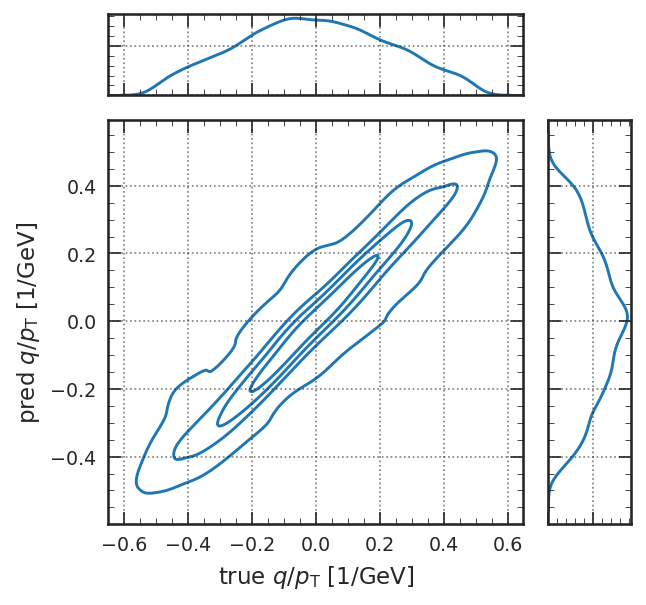

In [19]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true_1)
yy = np.squeeze(y_test_pred_1)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

df = pd.DataFrame({'x': xx, 'y': yy})
sns.kdeplot(data=df, x='x', y='y', levels=5, bw_adjust=1, ax=ax)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
sns.kdeplot(data=df, x='x', bw_adjust=1, ax=ax_top)
ax_top.set_xlabel('')
ax_top.set_ylabel('')
ax_top.tick_params(labelbottom=False, labelleft=False)
sns.kdeplot(data=df, y='y', bw_adjust=1, ax=ax_right)
ax_right.set_xlabel('')
ax_right.set_ylabel('')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

[INFO    ] mu, sig, mse, mae, mad: 1.2653e-03, 0.0694, 0.0076, 0.0552, 0.0536
[INFO    ] gaus fit (a, mu, sig): 7248.55, 1.2099e-03, 0.0489
[INFO    ] mu, sig, mse, mae, mad: 1.8536e-03, 0.0404, 0.0044, 0.0448, 0.0448
[INFO    ] gaus fit (a, mu, sig): 634.31, 2.4244e-03, 0.0397


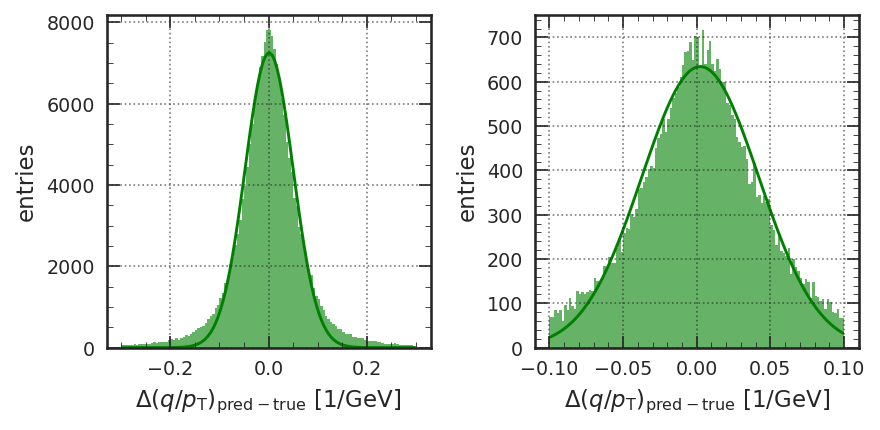

In [20]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(y_test_true)
yb = np.squeeze(y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy) < 0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 0.1]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.1,0.1), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

[INFO    ] mu, sig, mse, mae, mad: 4.4212e-02, 0.4183, 21417.6641, 2.3604, 0.3372
[INFO    ] gaus fit (a, mu, sig): 7986.54, 8.1634e-04, 0.2567
[INFO    ] mu, sig, mse, mae, mad: -2.1267e-01, 0.5635, 6550.6841, 3.7616, 0.8496
[INFO    ] gaus fit (a, mu, sig): 991.13, -4.0499e-01, 0.4539


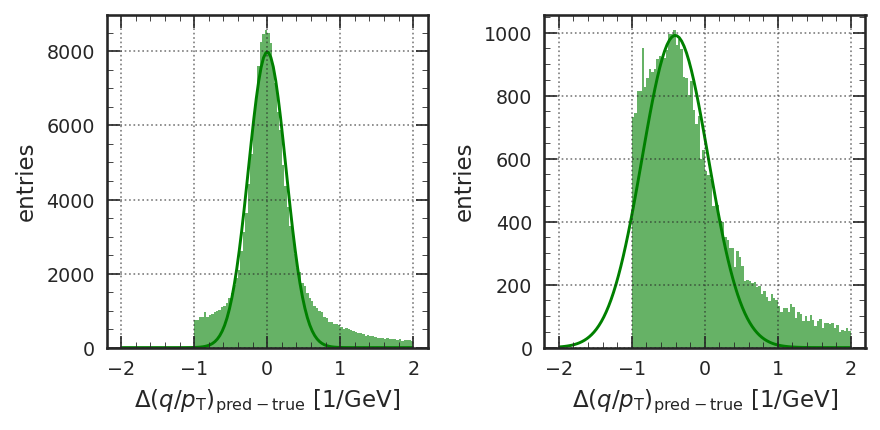

In [21]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(np.abs(y_test_true / y_test_true))
yb = np.squeeze(np.abs(y_test_true / y_test_pred))
yy = yb - ya
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

/tmp/ipykernel_9199/2259293510.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
/tmp/ipykernel_9199/2259293510.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
/tmp/ipykernel_9199/2259293510.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
/tmp/ipykernel_9199/2259293510.py:27: MatplotlibDeprecati

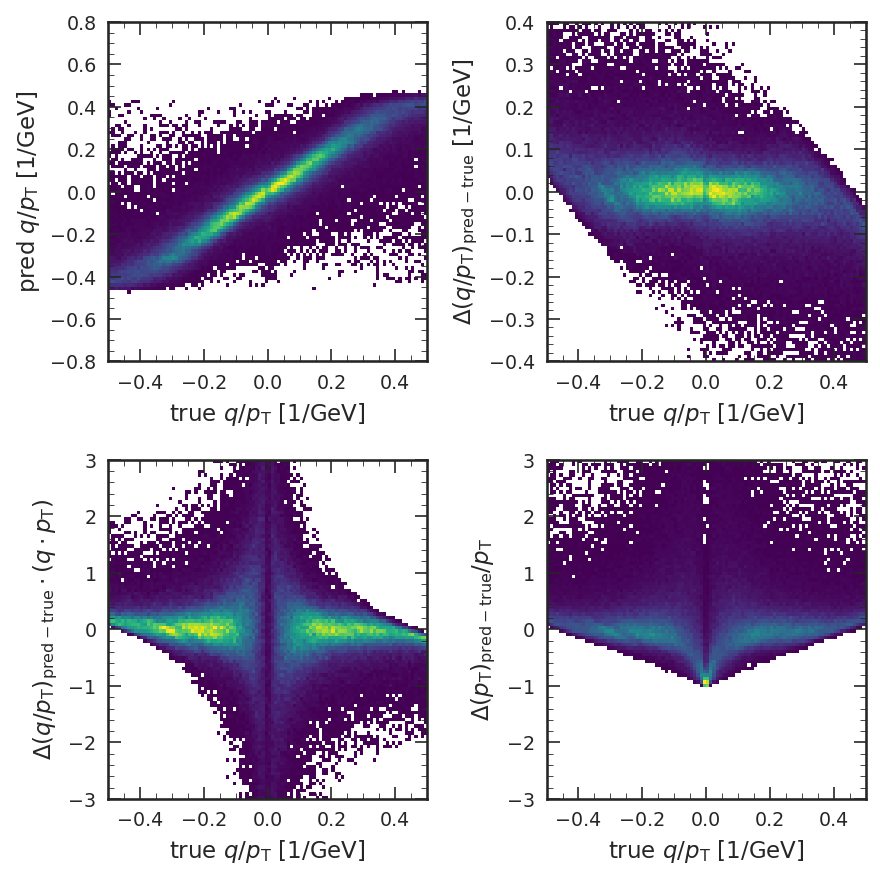

In [22]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)
ax = axs[0,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = np.squeeze(y_test_pred - y_test_true)
ax = axs[0,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

with np.errstate(divide='ignore'):
  yy = np.squeeze((y_test_pred - y_test_true) / np.abs(y_test_true))
ax = axs[1,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

with np.errstate(divide='ignore'):
  yy = np.squeeze(np.abs(y_test_true / y_test_pred) - 1)
ax = axs[1,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [23]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.squeeze(np.abs(y_test_true))
yy = np.squeeze(np.abs(y_test_true/y_test_pred) - 1)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xx_pt = np.zeros(nbinsx, dtype=np.float32)
yy_mu = np.zeros(nbinsx, dtype=np.float32)
yy_sig = np.zeros(nbinsx, dtype=np.float32)
yy_tail = np.zeros(nbinsx, dtype=np.float32)
yy_cov = np.zeros(nbinsx, dtype=np.float32)

cache = {}

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = xx_i.mean()
  pt = 1.0 / pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = yy_i.mean(), yy_i.std()
  assert np.abs(mu) < 1.0
  assert np.abs(sig) < 2.0

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1]) / 2
  try:
    popt = emtf_nbtools.fit_gaus(hist, edges, mu=mu, sig=sig)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  tail = tail.sum() / len(xx_i)

  pct = np.percentile(yy_i, (100 - 90), overwrite_input=True)  # find 10-percentile
  cov = -1 * pct / popt[2]
  # If truly gaussian, the required number of sigmas is 1.28155 for 90% coverage
  #print(scipy.special.erfinv(0.80) * np.sqrt(2))

  xx_pt[i] = pt
  yy_mu[i] = popt[1]
  yy_sig[i] = popt[2]
  yy_tail[i] = tail
  yy_cov[i] = cov

  if 14. < pt < 15.:
    cache[0] = (i, xx_i, yy_i)
  elif 20. < pt < 22.:
    cache[1] = (i, xx_i, yy_i)
  elif 25. < pt < 28.:
    cache[2] = (i, xx_i, yy_i)
  elif 28. < pt < 33.:
    cache[3] = (i, xx_i, yy_i)

[INFO    ] gaus fit (a, mu, sig): 61.87, -1.5007e-01, 0.3636
[INFO    ] gaus fit (a, mu, sig): 59.93, -2.3385e-01, 0.3747
[INFO    ] gaus fit (a, mu, sig): 56.38, -3.1432e-01, 0.3878
[INFO    ] gaus fit (a, mu, sig): 59.21, -3.8995e-01, 0.3664


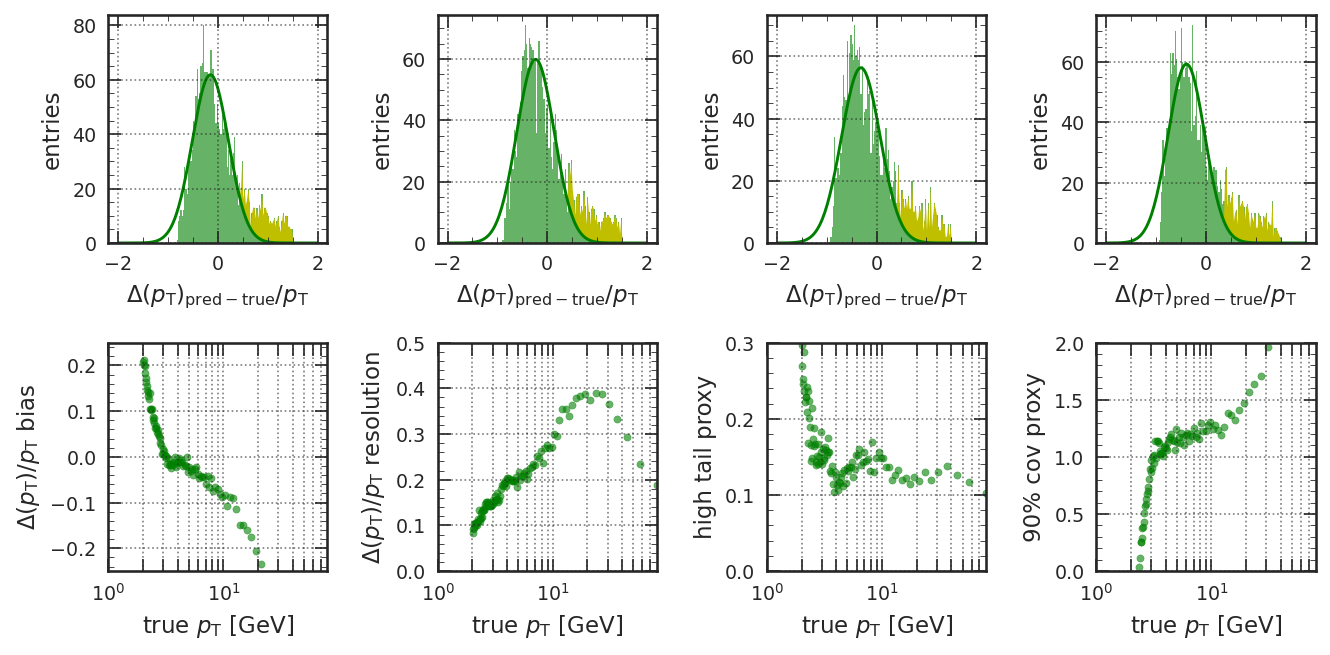

In [24]:
# Make better resolution plot
fig, axs = plt.subplots(2, 4, figsize=(9, 9/2), tight_layout=True)

for i in range(4):
  ax = axs[0,i]
  (ii, xx_i, yy_i) = cache[i]  # read from cache
  hist, edges, _ = ax.hist(yy_i, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  popt = emtf_nbtools.fit_gaus(hist, edges, mu=yy_mu[ii], sig=yy_mu[ii])
  xdata = (edges[1:] + edges[:-1])/2
  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata + tail, facecolor='y')
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')
  logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

ax = axs[1,0]
ax.scatter(xx_pt, yy_mu, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')

ax = axs[1,1]
ax.scatter(xx_pt, yy_sig, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')

ax = axs[1,2]
ax.scatter(xx_pt, yy_tail, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail proxy')

ax = axs[1,3]
ax.scatter(xx_pt, yy_cov, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'90% cov proxy')

plt.show()

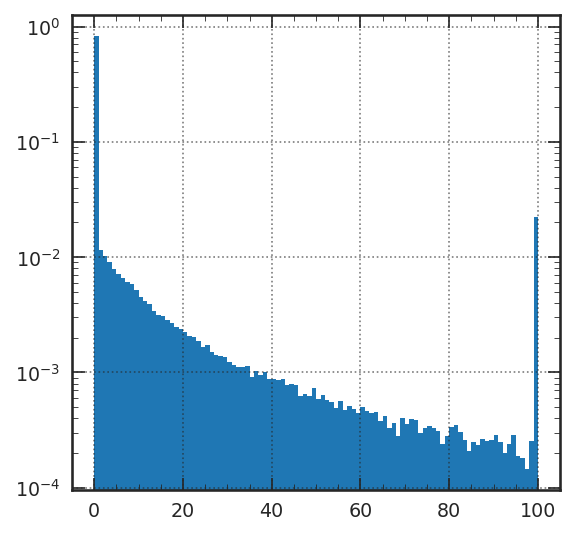

[INFO    ] regularization_pt_output: 293897/1548049 = 0.18985


In [25]:
# Check regularization loss
def regularization_pt_output():
  regularization = model.get_layer('regularization')
  x = regularization.loss_fn._data
  y = regularization.loss_fn._model(x, training=False)
  l1, bias = regularization.l1, regularization.bias
  clip_value_min, clip_value_max = 0., 100.
  y_as_pt = tf.math.reciprocal_no_nan(tf.math.abs(y))
  new_y_as_pt = tf.clip_by_value(y_as_pt - bias, clip_value_min, clip_value_max)
  return np.squeeze(new_y_as_pt.numpy())

fig, ax = plt.subplots()
yy = regularization_pt_output()
ax.hist(yy, bins=100, range=(0,100), density=True)
ax.set_yscale('log')
plt.show()

logger.info('regularization_pt_output: {}/{} = {:.5f}'.format(
    np.count_nonzero(yy), yy.shape[0], np.count_nonzero(yy) / yy.shape[0]))

### Calibrate pt

### Inspect weights